# Atlas image postprocessing - OTS manual labels

- parse labels (distinct colors) into separate channels
- other processing: e.g. translation

In [4]:
import nilearn as ni
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import colors

import os
import numpy as np
import pandas as pd

from PIL import Image
from PIL import ImageOps
from PIL import ImagePalette

In [5]:
NLABELS = 2

data_dir = '/scratch/groups/jyeatman/samjohns-projects/data'
input_parc_dir = data_dir + '/ots-parc-images-jitter'
input_curv_dir = data_dir + '/ots-curv-images-jitter'
output_image_base_dir = data_dir + '/ots-images-jitter-processed'
output_curv_dir = output_image_base_dir + '/curv'
output_parc_dir = output_image_base_dir + '/parc'

os.makedirs(output_image_base_dir, exist_ok=True)
os.makedirs(output_curv_dir, exist_ok=True)
os.makedirs(output_parc_dir, exist_ok=True)

parc_fps = os.listdir(input_parc_dir)
curv_fps = os.listdir(input_curv_dir)

In [6]:
len(parc_fps), len(curv_fps)

(800, 800)

In [31]:
# visualize a few images
ind = 600
img_p = Image.open(f'{input_parc_dir}/{parc_fps[ind]}')
img_c = Image.open(f'{input_curv_dir}/{curv_fps[ind]}')

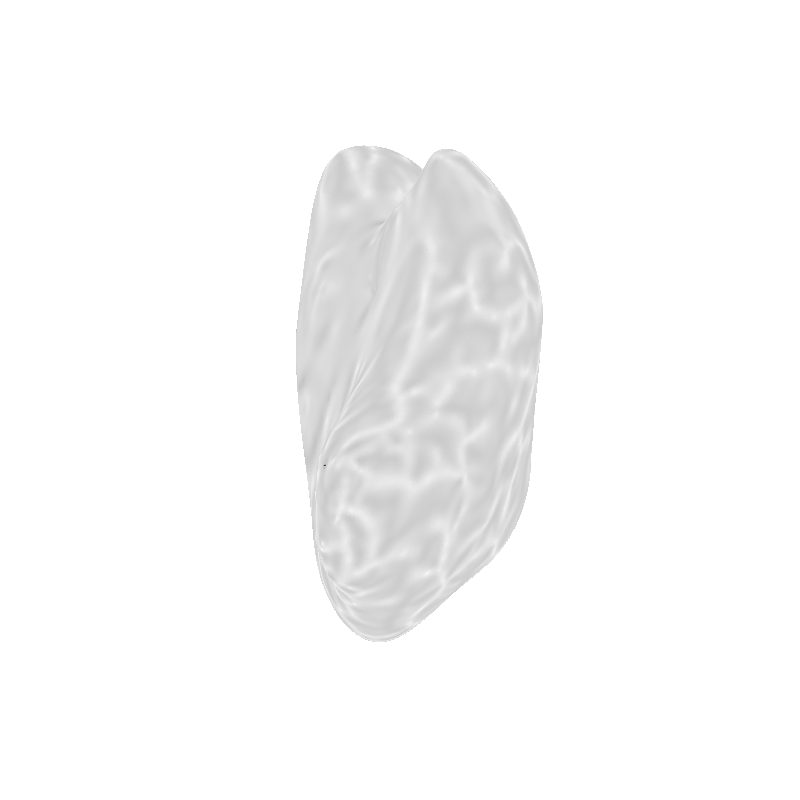

In [35]:
img_c

In [41]:
cmap = colors.ListedColormap(['blue', 'green', 'yellow', 'red', 'purple'])
bounds = [1, 2, 3, 4, 5, 6]

small_colorlist = [colors.to_rgb(c) for c in cmap.colors]
small_colors = 255 * np.array(small_colorlist)
pal_small = np.concatenate(([[255., 255., 255.]], small_colors))

In [43]:
tab20 = cm.get_cmap('tab20')
tab20_colors = 255 * np.array(tab20.colors)
pal_tab20 = np.concatenate(([[255., 255., 255.]], tab20_colors))

In [44]:
# same parameters for all images
def crop(image):
    """ Cropping helper function.
        Assumes input has correct y dimensions and
        x dim >= y dim; trims excess x dim to make a square.
    """
    x0, y0 = image.size   
    diff = (x0 - y0) / 2
    xl, xr = diff, x0 - diff
    ltrb = (xl, 0, xr, y0)
    return image.crop(ltrb)

def resize(image, newsize=256):
    return image.resize((newsize, newsize))

def process(image, newsize=256, grayscale=True):
    """Crops image, resizes, and converts to grayscale."""
    image = crop(image)
    image = resize(image, newsize)
    if grayscale:
        image = ImageOps.grayscale(image)
    return image

In [45]:
def get_closest_color(col, pal):
    return np.abs(col - pal).sum(axis=1).argmin()

In [46]:
def to_channel_img(img, pal):
    """ Converts an image into an image with one scalar value
        for each color in a specified palette. Each pixel's
        value is determined to be the index (in the palette)
        of the color that is closest to the pixel's original
        value.
        
        Note: expects image in RGBA PNG format, e.g. image
        shape should be (x_len, y_len, 4)).
    """
    img_np = np.array(img)
    img_colors = img_np[:, :, :-1] # remove alpha channel
    s = img_np.shape  
    ret_img = np.zeros(s[:-1])
    e = np.eye(pal.shape[0])

    # loop over pixels
    for x in range(s[0]):
        for y in range(s[1]):
            px_color = img_colors[x, y]
            cc = get_closest_color(px_color, pal)
            ret_img[x, y] = cc
    return ret_img

In [49]:
def process_img(img_fp, pal, img_out_fp=None, newsize=256):
    """ Downsamples an image, converts it to a numpy array,
        resamples each pixel color to nearest color
        in a specified palette (pal),
        and saves the result as a numpy array.
        Arguments:
            img_fp: full filepath to an RGBA image
            pal: palette to resample to (np array of shape (nclrs, 3))
            img_out_fp: if None, output is not saved
            newsize: size to resize to (image should be square)
        Returns:
            the resulting np array of shape (newsize, newsize,)
            with values in the range 0, pal.shape[0] - 1
    """
    img = Image.open(img_fp)
    img = img.resize((newsize, newsize))
    img_channel = to_channel_img(img, pal)
    
    # save (optionally)
    if img_out_fp is not None:
        np.save(img_out_fp, img_channel)
    
    return img_channel

In [50]:
# filter to process only new images
done_parc_imgs = [s.split('parc')[0]+'parc.png' for s in os.listdir(output_parc_dir)]

In [51]:
todo_parc_fps = [fp for fp in parc_fps if not (fp in done_parc_imgs)]

In [53]:
len(todo_parc_fps)

800

In [55]:
for i, f in enumerate(todo_parc_fps):
    img_fp = f'{input_parc_dir}/{f}'
    out_fname = f[:-4]
    out_fp = f'{output_parc_dir}/{out_fname}'
    process_img(img_fp, pal_small, img_out_fp=out_fp)
    if i > 0 and i % 20 == 0:
        print(f'Processed {i} parc images...')

Processed 20 parc images...
Processed 40 parc images...
Processed 60 parc images...
Processed 80 parc images...
Processed 100 parc images...
Processed 120 parc images...
Processed 140 parc images...
Processed 160 parc images...
Processed 180 parc images...
Processed 200 parc images...
Processed 220 parc images...
Processed 240 parc images...
Processed 260 parc images...
Processed 280 parc images...
Processed 300 parc images...
Processed 320 parc images...
Processed 340 parc images...
Processed 360 parc images...
Processed 380 parc images...
Processed 400 parc images...
Processed 420 parc images...
Processed 440 parc images...
Processed 460 parc images...
Processed 480 parc images...
Processed 500 parc images...
Processed 520 parc images...
Processed 540 parc images...
Processed 560 parc images...
Processed 580 parc images...
Processed 600 parc images...
Processed 620 parc images...
Processed 640 parc images...
Processed 660 parc images...
Processed 680 parc images...
Processed 700 parc

In [108]:
# test_img_fromarray = Image.fromarray((255/19)*test_img_channel)

In [114]:
# testing
# test_img_fromarray.getcolors()
# test_img_fromarray.convert(mode='L')

In [56]:
def process_curv(img_fp, newsize=256, img_out_fp=None):
    """Crops image, resizes, and converts to grayscale."""
    img = Image.open(img_fp)
    img = img.resize((newsize, newsize))
    img = ImageOps.grayscale(img)
    img_np = np.array(img)
    if img_out_fp is not None:
        np.save(img_out_fp, img_np)
    return img_np

In [57]:
for i, f in enumerate(curv_fps):
    img_fp = f'{input_curv_dir}/{f}'
    out_fname = f[:-4]
    out_fp = f'{output_curv_dir}/{out_fname}'
    process_curv(img_fp, img_out_fp=out_fp)
    if i > 0 and i % 20 == 0:
        print(f'Processed {i} curvature images...')

Processed 20 curvature images...
Processed 40 curvature images...
Processed 60 curvature images...
Processed 80 curvature images...
Processed 100 curvature images...
Processed 120 curvature images...
Processed 140 curvature images...
Processed 160 curvature images...
Processed 180 curvature images...
Processed 200 curvature images...
Processed 220 curvature images...
Processed 240 curvature images...
Processed 260 curvature images...
Processed 280 curvature images...
Processed 300 curvature images...
Processed 320 curvature images...
Processed 340 curvature images...
Processed 360 curvature images...
Processed 380 curvature images...
Processed 400 curvature images...
Processed 420 curvature images...
Processed 440 curvature images...
Processed 460 curvature images...
Processed 480 curvature images...
Processed 500 curvature images...
Processed 520 curvature images...
Processed 540 curvature images...
Processed 560 curvature images...
Processed 580 curvature images...
Processed 600 curv

In [36]:
out_fp

'/scratch/groups/jyeatman/samjohns-projects/data/ots-images-jitter-processed/curv/6121_T1.long.6121-210.56-75.82-curv'

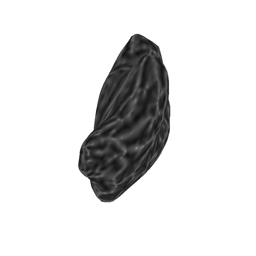

In [37]:
test_np = np.load(out_fp+'.npy')
img_test = Image.fromarray(test_np)
img_test.convert(mode='RGB')

In [39]:
test_parc = np.load(f'{output_parc_dir}/{parc_fps[0][:-4]}.npy')

In [46]:
np.unique(10*test_parc)

array([  0.,  10.,  20., 100., 110., 150., 190.])

In [61]:
import copy

In [69]:
test_parc_filt = copy.deepcopy(test_parc)
test_parc_filt[test_parc_filt != 19.0] = 0.0

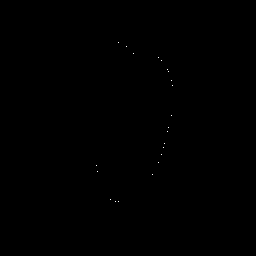

In [70]:
img_test_parc = Image.fromarray(100*test_parc_filt)
img_test_parc.convert(mode='RGB')

In [54]:
np.unique(test_parc, return_counts=True)

(array([ 0.,  1.,  2., 10., 11., 15., 19.]),
 array([55222,  8838,   154,    47,  1147,   106,    22]))

In [ ]:
cdict = {
'red'  :  ((0., 0., 0.), (0.5, 0.25, 0.25), (1., 1., 1.)),
'green':  ((0., 1., 1.), (0.7, 0.0, 0.5), (1., 1., 1.)),
'blue' :  ((0., 1., 1.), (0.5, 0.0, 0.0), (1., 1., 1.))
}

my_cmap = mpl.colors.LinearSegmentedColormap('my_colormap', cdict, 3)

plt.imshow(num_stars, extent=(min(x), max(x), min(y), max(y)), cmap=my_cmap)
plt.show()